In [20]:
%matplotlib inline

import numpy as np
import xarray as xr
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import geopandas as gpd
plt.rcParams['figure.figsize'] = (15,9)
from matplotlib.patches import Rectangle

In [21]:
import cartopy.crs as ccrs

In [22]:
shapefile= gpd.read_file('greatlakes_subbasins.shp')

In [23]:
ds1 = xr.open_dataset('zg_Amon_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_201001-201412.nc')
hgt = ds1.zg.sel(lat=slice(-10,90), lon=slice(180.5, 360),plev=slice(6) ,time=slice('2010-01-01','2014-12-31'))
lat_zg = ds1.lat.sel(lat=slice(-10,90))
lon_zg = ds1.lon.sel(lon=slice(180.5, 360))

In [24]:
hgt2d = hgt.values
ntime,nlevel, nrow_zg, ncol_zg = hgt2d.shape
print(nrow_zg,ncol_zg)

107 191


In [25]:
a= pd.read_csv("z_anom_mpi.csv")
b=pd.read_csv("mpi_anom_mean.csv")


In [26]:
a= a.drop(['Unnamed: 0'],axis=1)
b=b.drop(['Unnamed: 0'],axis=1)

In [27]:
a_zg = PCA(n_components=3)
a_zg.fit(a)
z= a_zg.explained_variance_ratio_
sum(z)

0.7897264457606806

In [28]:
a2d_pcs =  a_zg.inverse_transform(a_zg.transform(a))

In [29]:
b2d_pcs =  b

In [30]:
cca = CCA(n_components=4)
a_c, b_c = cca.fit_transform(b2d_pcs, a2d_pcs)

In [31]:
cca = CCA(n_components=4)
a_c, b_c = cca.fit_transform(b2d_pcs, a2d_pcs)

In [32]:
r=np.corrcoef(a_c[:, 0], b_c[:, 0])
r1=np.corrcoef(a_c[:, 1], b_c[:, 1])

In [33]:
r

array([[1.        , 0.52378221],
       [0.52378221, 1.        ]])

In [34]:
A = cca.x_weights_ 
B = cca.y_weights_
BB = np.reshape(B,(nrow_zg,ncol_zg,4),order='F')
BB_1= BB[:,:,0]


In [35]:
shapefile['cca1']= A[:,0]
shapefile.head()

merge                                           geometry      cca1
0   lk_erie  POLYGON ((-80.27591 44.09303, -80.26687 44.085... -0.197745
1  lk_huron  POLYGON ((-79.85601 47.28073, -79.85985 47.239... -0.660081
2   lk_mich  POLYGON ((-86.11485 46.54744, -86.11092 46.546...  0.150972
3    lk_ont  POLYGON ((-78.40375 45.35472, -78.40661 45.341...  0.682628
4    lk_sup  POLYGON ((-88.52978 50.74652, -88.50701 50.692... -0.190829

In [36]:
xmax,ymin,xmin,ymax= shapefile.total_bounds
d1=xmax-xmin
d2=ymax-ymin
rect =Rectangle((xmin, ymin), d1, d2, facecolor="none", ec='k', lw=2)

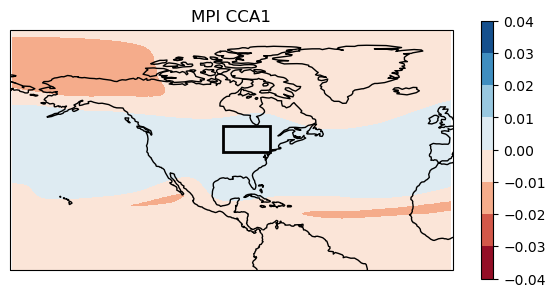

In [37]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 2)
gs.update(wspace=0.1, hspace=0.15)

ax2 = fig.add_subplot(gs[0,1],  projection=ccrs.PlateCarree())
x1, y1 = np.meshgrid(lon_zg, lat_zg)
level= np.arange(-0.04,0.05,0.01)
cs = ax2.contourf(x1, y1, BB_1,level,
                        
                        transform=ccrs.PlateCarree(),
                        cmap='RdBu')
    
cb=fig.colorbar(cs, ax=ax2, shrink=0.8, aspect=20)    
ax2.coastlines()
ax2.set_global()
ax2.set_extent([-180,0,-7.5,90],crs=ccrs.PlateCarree())
ax2.set_title('MPI CCA1')

ax2.add_patch(rect)

fig.savefig('CCA1_MPI_basin')

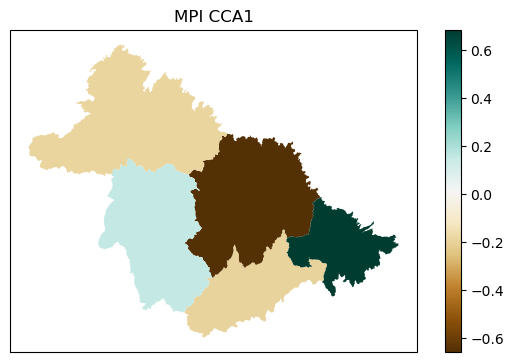

In [39]:
fig2 = plt.figure()
gs = gridspec.GridSpec(2, 2)
gs.update(wspace=0.1, hspace=0.15)

ax1 = fig2.add_subplot(gs[0,1],  projection=ccrs.PlateCarree())
shapefile.plot(ax=ax1,column ="cca1", cmap = reversed_map,legend=True)
ax1.set_title('MPI CCA1')
fig2.savefig('mpi_pr')

In [22]:
a_c /= a_c.std(axis=0)
b_c /= b_c.std(axis=0)

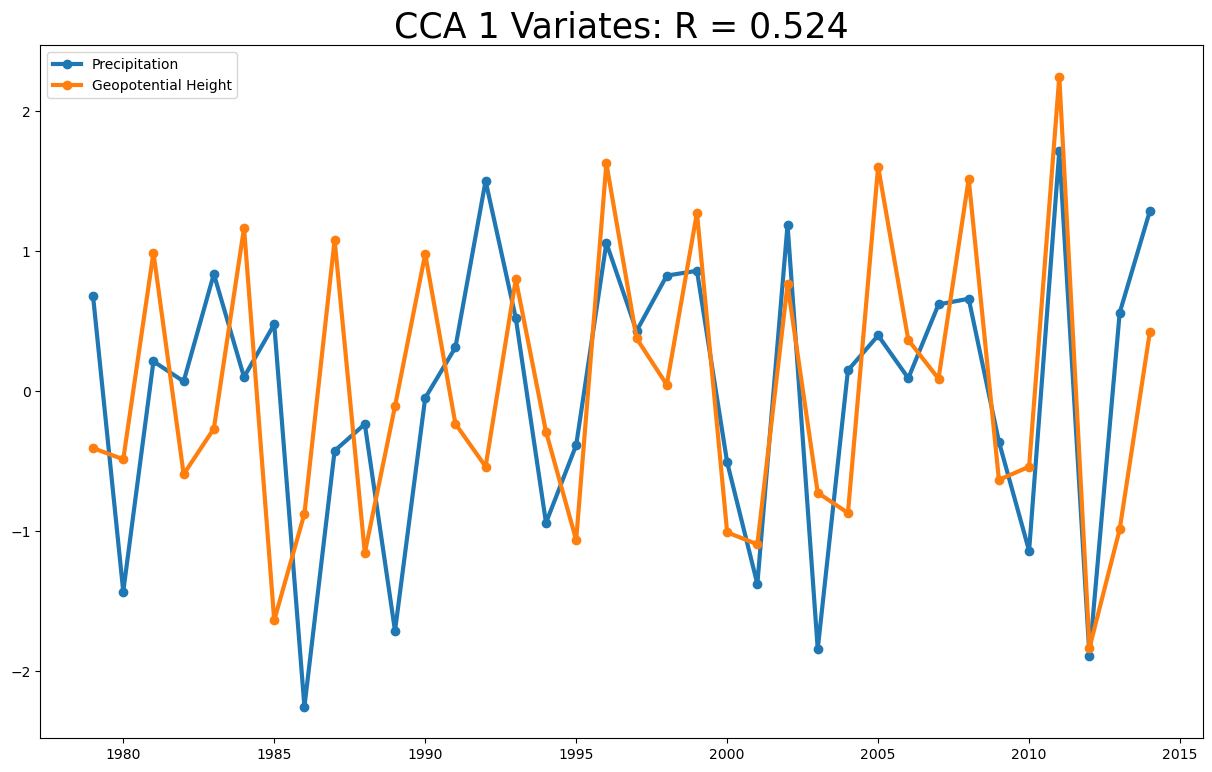

In [24]:
year = list(range(1979,2015))
fontsize = 25
plt.plot(year, a_c[:,0],"-o", label='Precipitation',linewidth=3)
plt.plot(year, b_c[:,0],"-o", label='Geopotential Height',linewidth=3)
plt.title('CCA 1 Variates: R = ' + str(round(r[0,1],3)),fontdict={'fontsize': fontsize})
plt.legend()
plt.savefig('basin_mpi')